In [1]:
import itertools
import matplotlib.pyplot as plt
import os
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [30]:
# Function to load and preprocess data
def load_and_preprocess_data(three_ms_path, cap_path):
    df_3ms = pd.read_csv(three_ms_path).drop(columns=['Unserved Energy', 'Over Generation'])
    df_3ms['ts'] = pd.to_datetime(df_3ms['ts'])
    
    df_cap_2025 = pd.read_csv(cap_path).query('Year == 2025').replace({'Land-based Wind': 
        'Onshore Wind'}).drop(columns=['Unnamed: 0', 'Year'])
    
    relevant_technologies = df_3ms.columns.intersection(df_cap_2025['Technology'])
    cap_mapping = df_cap_2025.set_index('Technology')['Energy Capacity (MW)'].to_dict()

    # Calculate mismatch between generation and capacity
    for tech in relevant_technologies:
        df_3ms[f'{tech} Capacity (MW)'] = cap_mapping.get(tech, 0)
        df_3ms[f'{tech} Mismatch'] = df_3ms[tech] - df_3ms[f'{tech} Capacity (MW)']

    df_3ms['Total Mismatch'] = df_3ms.filter(like='Mismatch').sum(axis=1)
    df_3ms.set_index('ts', inplace=True)
    return df_3ms.resample('D').mean().reset_index()

In [37]:
# Function to plot mismatch over time
def plot_mismatch(df, title, technologies=None):
    plt.figure(figsize=(14, 10))

    # If technologies is None, filter only for columns that contain 'Mismatch'
    if technologies is None:
        technologies = [col for col in df.columns if 'Mismatch' in col and col != 'Total Mismatch']
    
    # Plot mismatch for each technology
    for tech in technologies or df.columns:
        plt.plot(df.index, df[tech], label=tech.replace(' Mismatch', ''), linewidth=2)
    
    # plt.axhline(0, color='black', linestyle='--', label='Zero Mismatch')
    plt.xlabel('Time')
    plt.ylabel('Mismatch (MW) - Difference between Generated and Capacity')
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Technologies')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [5]:
# Function to decompose and plot time series components
def decompose_and_plot(df, column, period=30):
    # Decompose the time series
    decomp = seasonal_decompose(df[column], model='additive', period=period)
    
    # Set up the plot
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
    fig.suptitle(f'Seasonal Decomposition of {column}', fontsize=16)
    
    # Observed
    ax1.plot(decomp.observed, label='Observed', color='tab:blue')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('Observed')
    
    # Trend
    ax2.plot(decomp.trend, label='Trend', color='tab:orange')
    ax2.legend(loc='upper left')
    ax2.set_ylabel('Trend')
    
    # Seasonal
    ax3.plot(decomp.seasonal, label='Seasonal', color='tab:green')
    ax3.legend(loc='upper left')
    ax3.set_ylabel('Seasonal')
    
    # Residual
    ax4.plot(decomp.resid, label='Residual', color='tab:red')
    ax4.legend(loc='upper left')
    ax4.set_ylabel('Residual')
    ax4.set_xlabel('Date')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [6]:
# Function to fit ARIMA model
def fit_arima_model(train, order, seasonal_order=None):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    return model.fit()

In [7]:
# Function to forecast and plot the results
def forecast_and_plot(model, train, test, steps=90, energy_type='Mismatch'):
    # Forecasting
    forecast = model.get_forecast(steps=steps)
    forecasted_mean = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()
  
    # Generate date range for the forecast
    forecast_dates = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=steps, freq='D')
    
    # Plot the forecast with confidence intervals
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Observed (Training)', color='blue')
    plt.plot(test.index, test, label='Observed (Test)', color='green')
    plt.plot(forecast_dates, forecasted_mean, label='Forecast', color='red')
    plt.fill_between(forecast_dates, 
                     confidence_intervals.iloc[:, 0], 
                     confidence_intervals.iloc[:, 1], 
                     color='pink', 
                     alpha=0.5)
    plt.xlabel('Date')
    plt.ylabel('Mismatch')
    plt.title(f'{energy_type} Forecast')
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

In [8]:
# Function to perform grid search for the best ARIMA model
def grid_search_arima(df, column):
    p = d = q = range(0,2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]

    best_aic = float("inf")
    best_order, best_seasonal_order = None, None

    # Iterate over all possible combinations of parameters
    for order in pdq:
        for seasonal_order in seasonal_pdq:
            try:
                model = SARIMAX(df[column], 
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = order
                    best_seasonal_order = seasonal_order
            except Exception as e:
                print(f"An error occurred: {e}")
                continue

    return best_order, best_seasonal_order

In [9]:
# Function to run the ARIMA forecast pipeline
def run_arima_forecast(df, column_name, train, test, steps=90):
    """
    Perform ARIMA model grid search, fit the best model, and forecast.
    """
    # Find the best ARIMA orders
    best_order, best_seasonal_order = grid_search_arima(df, column_name)
    
    # Fit ARIMA model with best parameters
    model = fit_arima_model(df[column_name], best_order, best_seasonal_order)

    # Forecast and plot results
    forecast_and_plot(model, train, test, steps=90, energy_type=column_name)

In [10]:
# Function to run the complete ARIMA forecasting process
def arima_forecast_pipeline(df, column_name, train_size_ratio=0.8, steps=90):
    """
    Splits the data into training and testing sets, and runs ARIMA forecast.
    """
    train_size = int(len(df) * train_size_ratio)
    train, test = df.iloc[:train_size][column_name], df.iloc[train_size:][column_name]
    run_arima_forecast(df, column_name, train, test, steps)

In [11]:
# Read in csv files and preprocess data
path = r"C:\Users\prest\WGU\Capstone Project\IntegratedCapacityInvestment\3MS Working Copies"
three_ms_path = os.path.join(path, "3MS_2025.csv")
cap_path = os.path.join(path, "energy_cap_3MS.csv")

In [12]:
# Data exploration


In [13]:
# Preprocess data
df_3ms_daily = load_and_preprocess_data(three_ms_path, cap_path)
df_3ms_daily.set_index('ts', inplace=True)

Index(['Natural Gas Steam Turbine', 'Utility PV', 'Distributed PV',
       'Onshore Wind', 'Diesel', 'Coal', 'Landfill Gas', 'Hydropower',
       'Fuel Oil No. 6'],
      dtype='object')
{'10hr Storage': 333.9788833, '2hr Storage': 0.0, '4hr Storage': 740.0, '6hr Storage': 0.0, '8hr Storage': 0.0, 'Biodiesel': 0.0, 'Coal': 454.0, 'Diesel': 941.0, 'Distributed PV': 1245.100775, 'Fuel Oil No. 6': 880.0, 'Hydropower': 0.0, 'Onshore Wind': 343.4965668, 'Landfill Gas': 4.8, 'Natural Gas Combined Cycle': 930.0, 'Natural Gas Steam Turbine': 700.0, 'Offshore Wind': 0.0, 'Planned Utility PV': 1004.9, 'Utility PV': 1824.348919}


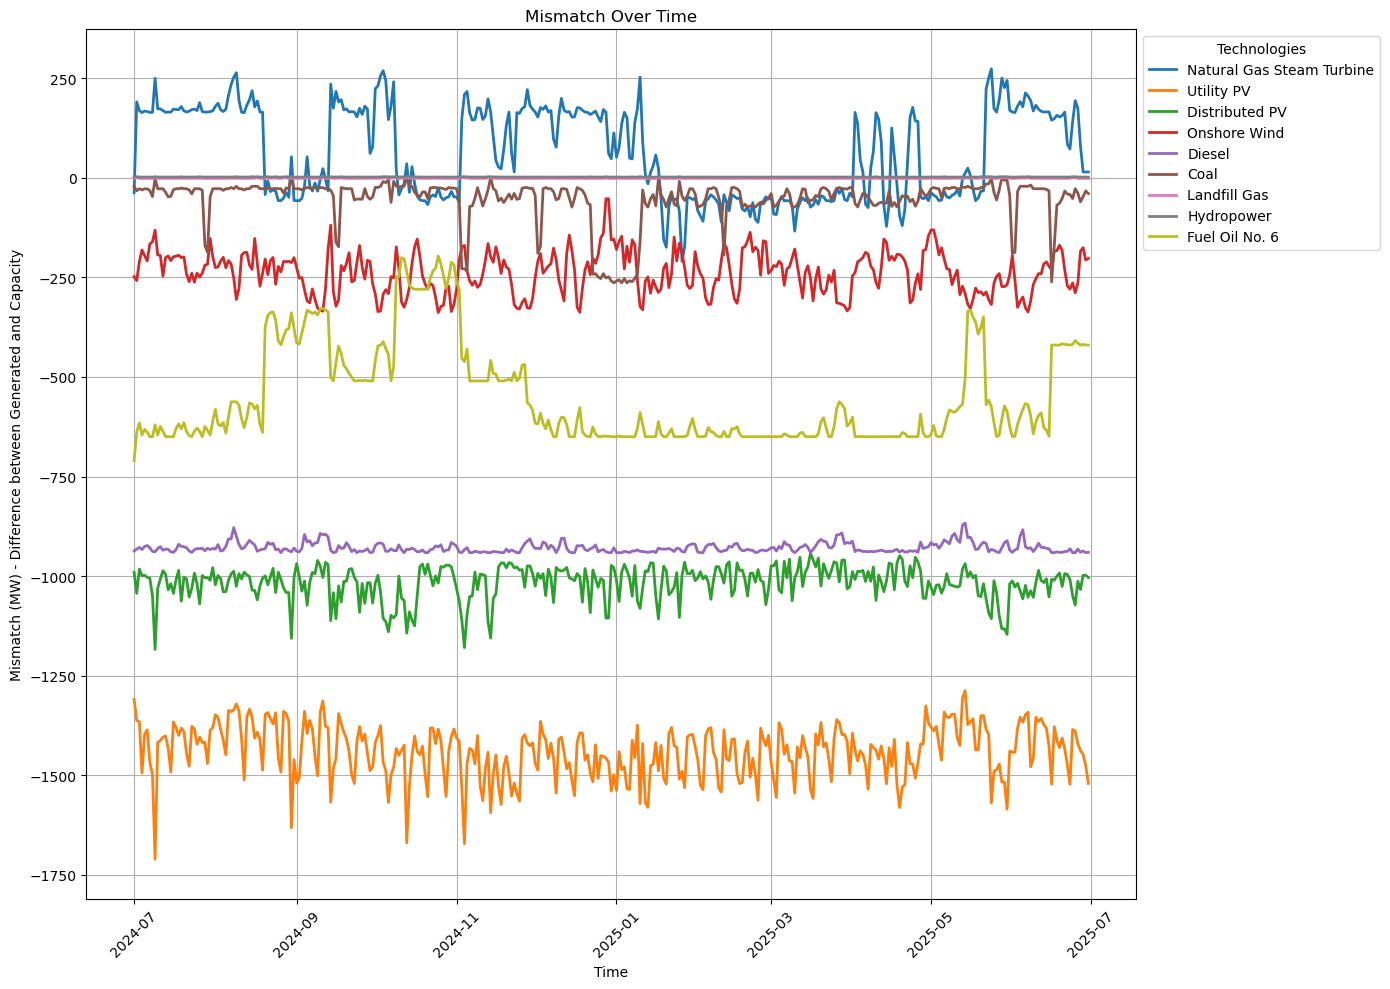

In [38]:
# Plot mismatch over time for relevant technologies
plot_mismatch(df_3ms_daily, 'Mismatch Over Time', [col for col in df_3ms_daily.columns if 'Mismatch' in col and col != 'Total Mismatch'])

In [15]:
columns_list = ['Utility PV Mismatch', 'Distributed PV Mismatch', 'Onshore Wind Mismatch']

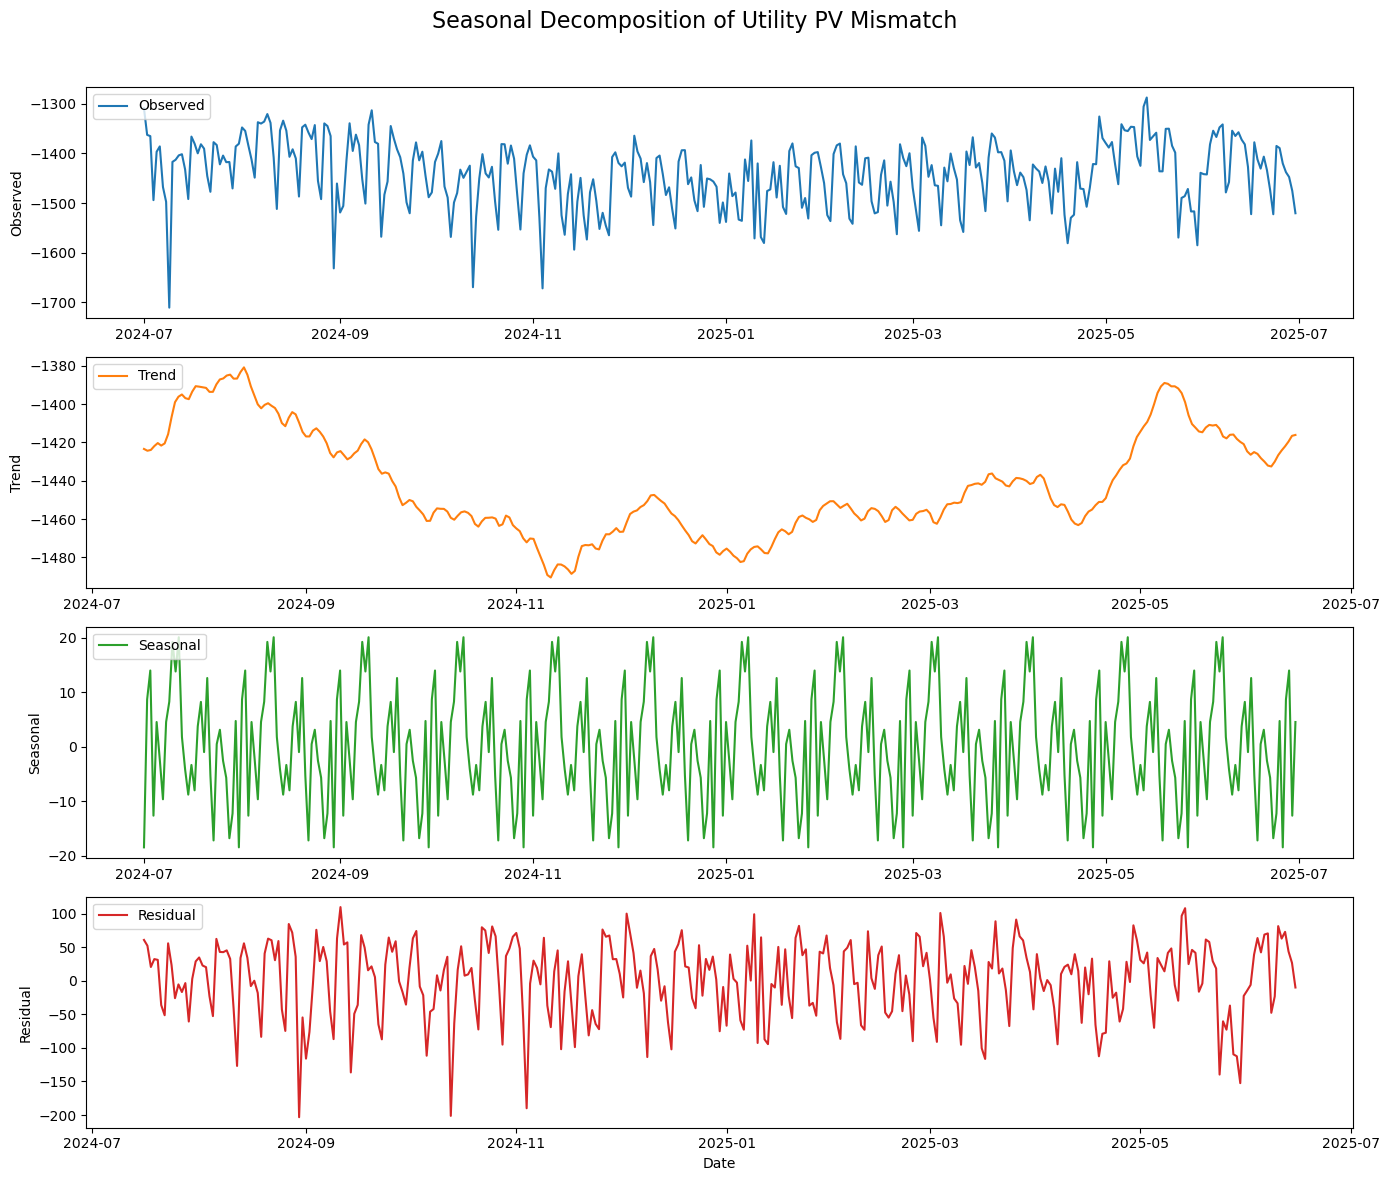

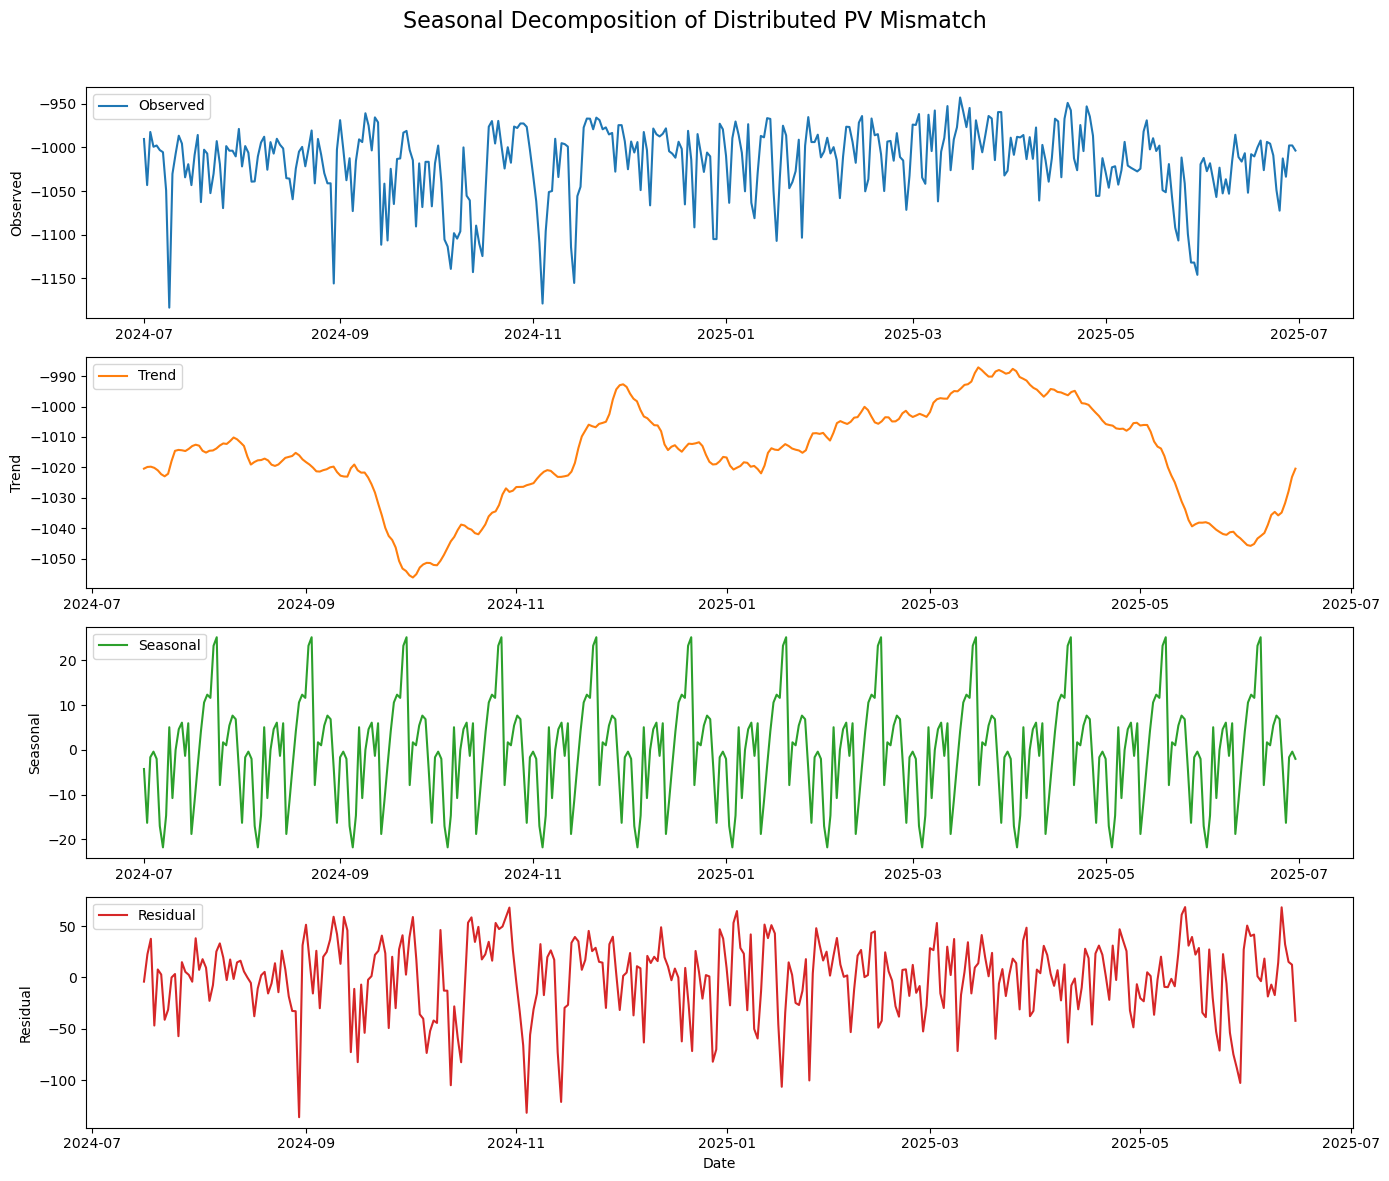

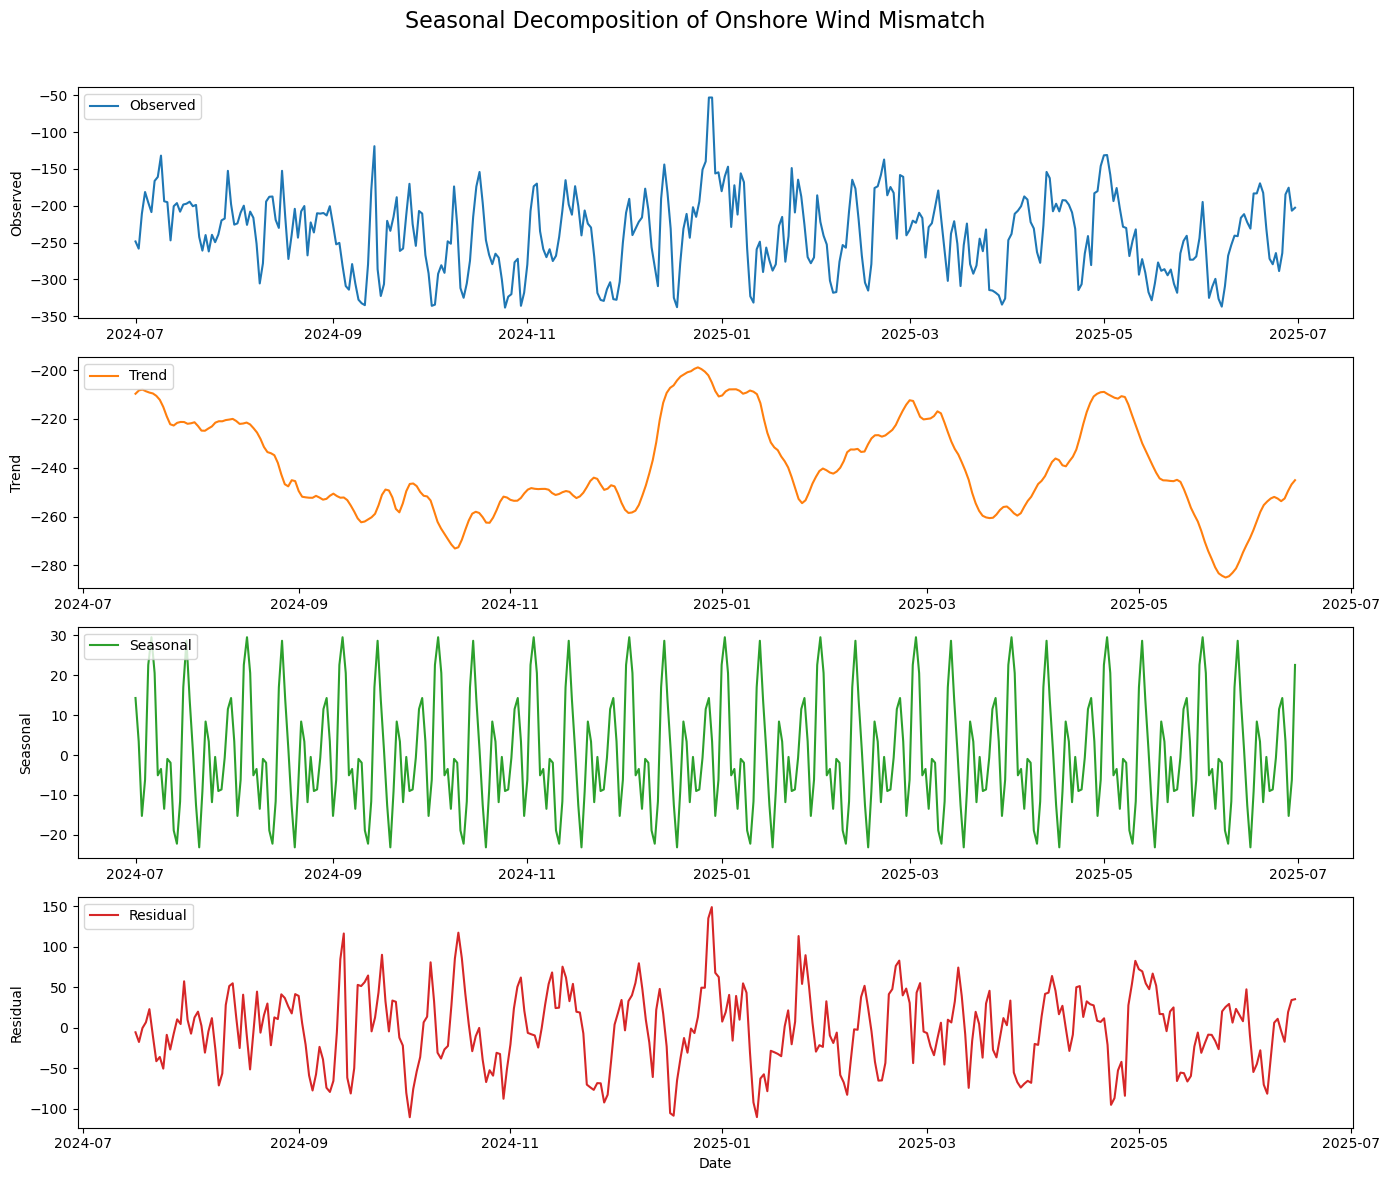

In [16]:
# Run seasonal decomposition for selected columns
for column in columns_list:
    decompose_and_plot(df_3ms_daily, column, period=30)

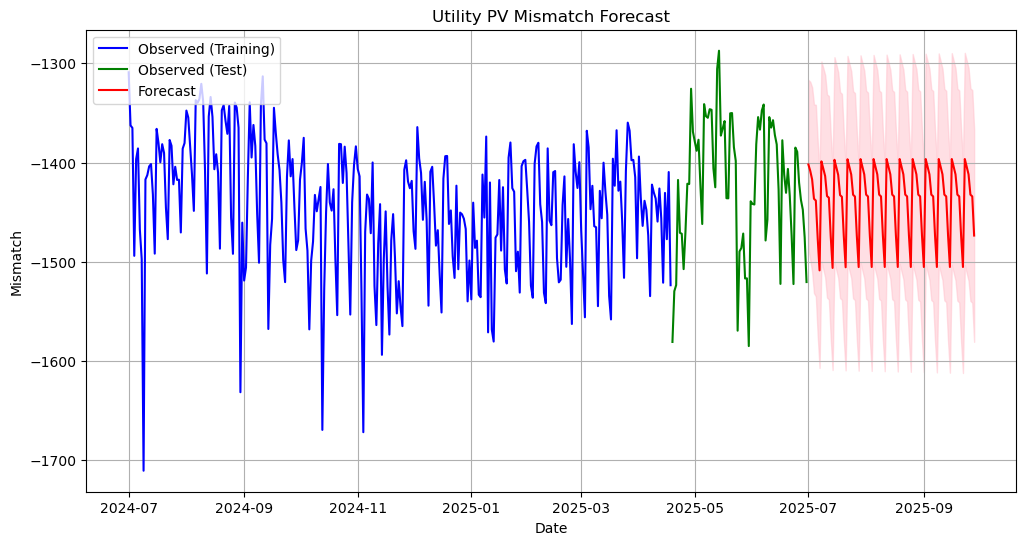

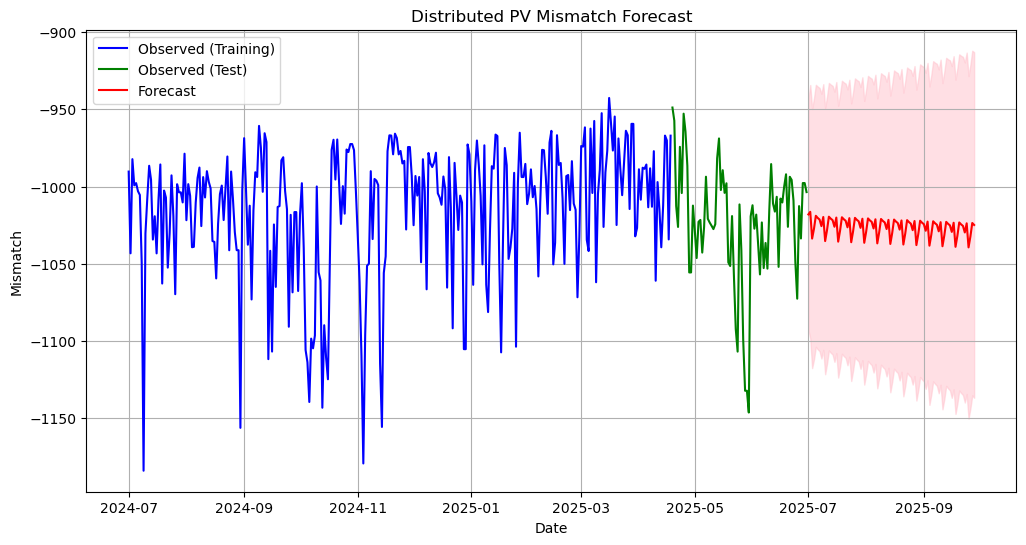

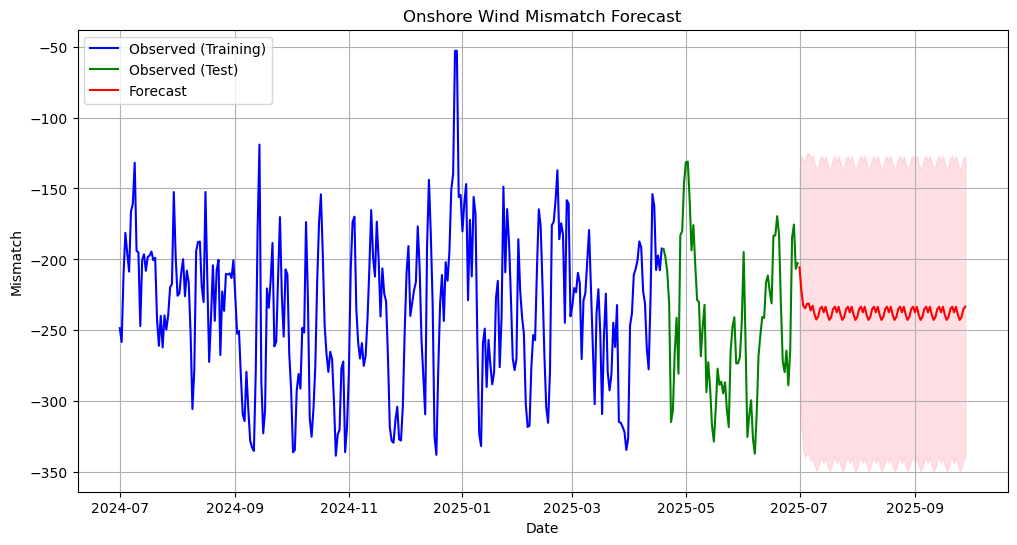

In [17]:
# Run ARIMA forecasting for selected columns
for column in columns_list:
    arima_forecast_pipeline(df_3ms_daily, column, train_size_ratio=0.8, steps=90)